<a href="https://colab.research.google.com/github/LucaViolone/CV-Depth/blob/main/clip_zero_shot_anatomy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Project README — CLIP zero-shot anatomy tagging + attention maps

- Note* make sure to download dataset and change the IMG_dir path to the folder in colab: https://drive.google.com/drive/folders/1QMRI0YUqyZVYA9Aig_ISmS6hRIYQI34G?usp=sharing
**Idea**: Zero-shot classification and localization of anatomical concepts with CLIP.
- **Method**: Use CLIP to score prompts like "arachnoid mater," "dura," "cranial nerve." Visualize Grad-CAM (RN50) or attention rollout (ViT) to localize. Optionally calibrate with 0–5 labeled images via temperature scaling or prompt ensembling.
- **Demo**: Provide an image set; do prompt engineering and ensembling; display top-k labels and heatmaps.
- **Why low-data**: Text supervision replaces labels.
- **How to run**: "Run All" the notebook. Add images to `images/` (or use provided Wikimedia examples). Optional: supply a tiny labeled set for calibration.
- **Outputs**: Per-image top-k label scores and Grad-CAM overlays; optional accuracy if labels exist; discuss domain shift and prompt failures.
- **File**: `clip_zero_shot_anatomy.ipynb`.
- **References**: CLIP (Radford et al., 2021) — https://arxiv.org/abs/2103.00020; Transformer interpretability — https://arxiv.org/pdf/2002.05709.
### - LUCA VIOLONE


# CLIP Zero-Shot Anatomy Tagging + Saliency Maps

This notebook demonstrates zero-shot classification and localization for anatomical concepts using CLIP. We score a set of anatomy prompts against images and visualize where the model "looks" using Grad-CAM (for the RN50 CLIP variant) to provide spatial saliency maps.

- Paper: Contrastive Language–Image Pretraining (CLIP) — https://arxiv.org/abs/2103.00020
- Goal: Show how text supervision enables low-data recognition and produce interpretable heatmaps.
- Contents: setup, prompt engineering, zero-shot scoring, Grad-CAM saliency, examples, and commentary.


In [11]:
# Install dependencies
!pip install -q open-clip-torch==2.24.0 ftfy==6.2.3 regex==2024.9.11 timm==1.0.9 matplotlib pillow opencv-python tqdm
# Check environment
import torch, platform
print("Python", platform.python_version())
print("Torch", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Python 3.12.11
Torch 2.8.0+cu126
CUDA available: True


In [2]:
import os, sys, math, random, json, glob, urllib.request
import io
import numpy as np
import torch # Add torch import back
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import open_clip
from tqdm import tqdm

# Reproducibility

def set_seed(seed: int = 3) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(3)

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
if device == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Device: cuda
GPU: Tesla T4


In [13]:
# Load CLIP (OpenCLIP) model and preprocess
# We will use RN50 for Grad-CAM support; ViT models are supported for attention rollout, but Grad-CAM is simpler on conv backbones.
model_name = "RN50"
pretrained = "openai"
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained, device=device)
tokenizer = open_clip.get_tokenizer(model_name)
model.eval();

print(f"Loaded {model_name} ({pretrained})")

# Labels and domain phrases
base_labels = [
    "arachnoid mater",
    "dura mater",
    "cranial nerve",
    "optic nerve",
    "cerebellum",
    "brainstem",
    "sulcus",
    "gyrus",
]

label_to_phrases = {
    "arachnoid mater": ["arachnoid mater", "arachnoid membrane", "subarachnoid space"],
    "dura mater": ["dura mater", "dural membrane", "dura"],
    "cranial nerve": ["cranial nerve", "cranial nerve root"],
    "optic nerve": ["optic nerve", "cranial nerve II", "optic nerve head", "optic disc"],
    "cerebellum": ["cerebellum", "cerebellar hemisphere", "vermis"],
    "brainstem": ["brainstem", "midbrain", "pons", "medulla oblongata"],
    "sulcus": ["cerebral sulcus", "sulcus"],
    "gyrus": ["cerebral gyrus", "gyrus"],
}

prompt_templates = [
    "an intraoperative photograph of {}",
    "an operating microscope photo of {}",
    "an endoscopic surgical view of {}",
    "a neurosurgical anatomy photo of {}",
    "a medical photograph of {}",
    "a close-up photo of {}",
    "an MRI of {}"
]

# Expand prompts per label using phrases/synonyms
label_to_prompts = {
    label: [tmpl.format(phrase) for phrase in label_to_phrases[label] for tmpl in prompt_templates]
    for label in base_labels
}

all_texts = sum(label_to_prompts.values(), [])  # flattened list
print("Num labels:", len(base_labels), "Num prompts:", len(all_texts))

with torch.no_grad():
    text_tokens = tokenizer(all_texts).to(device)
    text_features = model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

Loaded RN50 (openai)
Num labels: 8 Num prompts: 161


In [12]:
IMG_DIR = '/content/dataset' #change to path of dataset folder download: https://drive.google.com/drive/folders/1QMRI0YUqyZVYA9Aig_ISsC6hRIYQI34G?usp=sharing

# Define the image file extensions you want to find
image_extensions = ('*.jpg', '*.png', '*.jpeg', '*.gif')

# Collect all image paths from the folder
image_paths = []
# If nested folders:
image_paths = [p for ext in ("**/*.jpg","**/*.jpeg","**/*.png") for p in glob.glob(os.path.join(IMG_DIR, ext), recursive=True)]


image_paths.sort() # Ensure the list is sorted
print("Found images:", len(image_paths))
print(image_paths)

Found images: 14
['/content/dataset/Brain_with_arachnoid_and_pia_mater.jpg', '/content/dataset/Craniotomy_Arachnoid.jpg', '/content/dataset/Dura_dissection.png', '/content/dataset/Gross_pathology_of_subarachnoid_hemorrhage.jpg', '/content/dataset/Human_brain_inferior_view_description.jpeg', '/content/dataset/Human_brainstem-thalamus_posterior_view_description.jpeg', '/content/dataset/Human_brainstem_anterior_view_description_2.jpeg', '/content/dataset/Human_cerebellum_posterior_view_description.jpeg', '/content/dataset/Slide6uu.jpeg', '/content/dataset/Trigeminal_nerve_neurovascular_conflict_microscope.jpeg', '/content/dataset/Use_of_a_surgical_sealant_film,_TissuePatchDural_(Tissuemed,_Leeds,_UK)_to_reinforce_and_seal_gaps_in_the_dura_mater..jpeg', '/content/dataset/cranial_nerve_8.jpeg', '/content/dataset/dura_matter_microscope_clean.jpeg', '/content/dataset/optic_nerve.jpeg']


In [14]:
# Zero-shot scoring utilities
# Goal: encode an image and compare it to each text prompt; aggregate prompt scores by label.

def preprocess_pil(img: Image.Image) -> torch.Tensor:
    # Applies the CLIP preprocessing (resize/crop/normalize) and adds a batch dimension.
    return preprocess(img).unsqueeze(0)

@torch.no_grad()
def score_image_against_prompts(img: Image.Image, text_features: torch.Tensor, all_texts: list[str], T: float = 1.0) -> dict:
    # 1) Encode image to the CLIP embedding space
    image_input = preprocess_pil(img).to(device)
    image_features = model.encode_image(image_input)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    # 2) Compare image vector to every text vector (cosine similarity via dot product after norm)
    scale = float(model.logit_scale.exp().cpu())  # better than hard 100
    logits = (scale * image_features @ text_features.T)[0].float() / T
    # 3) Softmax over prompts gives a probability mass across all prompts
    probs = logits.softmax(dim=-1).cpu().numpy()
    return {prompt: float(p) for prompt, p in zip(all_texts, probs)}

# Aggregate prompt probabilities per label via mean (or max) across that label's prompts.
def aggregate_by_label(scores: dict, label_to_prompts: dict, reduce: str = "mean", multi_label: bool = False) -> dict:
    label_scores = {}
    for label, prompts in label_to_prompts.items():
        vals = [scores.get(p, 0.0) for p in prompts]
        if reduce == "mean":
            label_scores[label] = float(np.mean(vals))
        else:
            label_scores[label] = float(np.max(vals))

    if multi_label:
        # For multi-label, use sigmoid on aggregated logits
        class_logits = {lbl: float(np.mean([scores.get(p, 0.0) for p in label_to_prompts[lbl]])) for lbl in base_labels} # assuming scores are logits here for simplicity, ideally use pre-softmax logits
        class_probs = torch.tensor(list(class_logits.values())).sigmoid().numpy()
        label_scores = {label: float(prob) for label, prob in zip(base_labels, class_probs)}

    return label_scores

# Display top-k labels

def show_topk(label_scores: dict, k: int = 5):
    top = sorted(label_scores.items(), key=lambda x: x[1], reverse=True)[:k]
    for label, p in top:
        print(f"{label:18s}  {p:.3f}")

# Demo: score each image and show the top-5 labels.
for img_path in image_paths:
    img = Image.open(img_path).convert("RGB")
    print("\nImage:", os.path.basename(img_path))
    scores = score_image_against_prompts(img, text_features, all_texts, T=T_star)
    label_scores = aggregate_by_label(scores, label_to_prompts, reduce="mean", multi_label=False) # Use multi_label=True for multi-label
    show_topk(label_scores, k=5)


Image: Brain_with_arachnoid_and_pia_mater.jpg
arachnoid mater     0.047
dura mater          0.000
brainstem           0.000
sulcus              0.000
cerebellum          0.000

Image: Craniotomy_Arachnoid.jpg
dura mater          0.012
sulcus              0.008
cerebellum          0.007
optic nerve         0.006
brainstem           0.006

Image: Dura_dissection.png
sulcus              0.014
dura mater          0.012
arachnoid mater     0.007
brainstem           0.005
cerebellum          0.005

Image: Gross_pathology_of_subarachnoid_hemorrhage.jpg
sulcus              0.012
arachnoid mater     0.009
gyrus               0.009
brainstem           0.007
cerebellum          0.006

Image: Human_brain_inferior_view_description.jpeg
brainstem           0.016
gyrus               0.008
cerebellum          0.008
arachnoid mater     0.008
sulcus              0.005

Image: Human_brainstem-thalamus_posterior_view_description.jpeg
cranial nerve       0.019
optic nerve         0.008
dura mater         

### Educational: Zero-shot scoring and prompt ensembling
- Concept: CLIP embeds images and texts into the same space. We compare an image to many prompts and interpret higher cosine similarities as better matches.
- Prompt ensembling: averaging (or max) over multiple phrasings per label reduces sensitivity to wording.
- What you’ll see: a bar chart of label scores for a chosen image, then we proceed to saliency to understand where the evidence comes from.
- To create a saliency map with CLIP, a query and an image are given to the model. The method then analyzes how different regions of the image contribute to the overall similarity score between the image and the text query.
- The resulting map highlights which parts of the image were most influential in the model's judgment that the image matches the text description. For example, if the query is "a cat," the saliency map would likely highlight the pixels corresponding to the cat in the image. This helps to explain what the model is "looking at" when it makes a prediction.


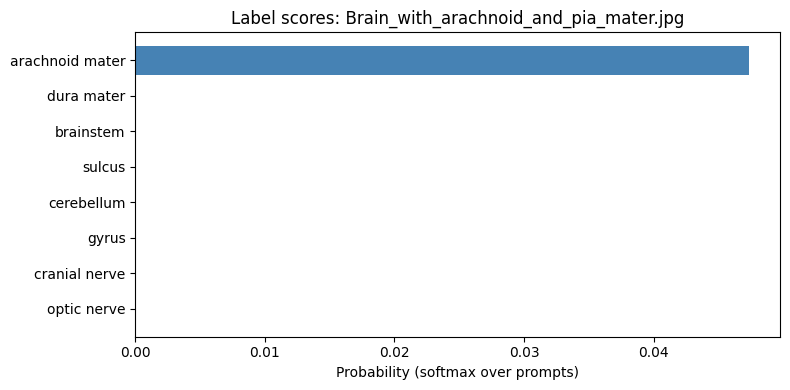

In [6]:
# Visualization: bar chart of label scores for a selected image
import numpy as np
import matplotlib.pyplot as plt

if len(image_paths) > 0:
    sel_idx = 0  # change index to visualize a different image
    img_path = image_paths[sel_idx]
    img = Image.open(img_path).convert("RGB")
    scores = score_image_against_prompts(img, text_features, all_texts)
    label_scores = aggregate_by_label(scores, label_to_prompts, reduce="mean")

    labels = list(label_scores.keys())
    vals = np.array([label_scores[k] for k in labels], dtype=float)
    order = np.argsort(-vals)
    labels_sorted = [labels[i] for i in order]
    vals_sorted = vals[order]

    plt.figure(figsize=(8, 4))
    plt.barh(labels_sorted[::-1], vals_sorted[::-1], color='steelblue')
    plt.xlabel('Probability (softmax over prompts)')
    plt.title(f'Label scores: {os.path.basename(img_path)}')
    plt.tight_layout(); plt.show()
else:
    print("No images found. Add images and rerun.")



Grad-CAM: Brain_with_arachnoid_and_pia_mater.jpg
Top label: arachnoid mater via prompt: an MRI of arachnoid mater


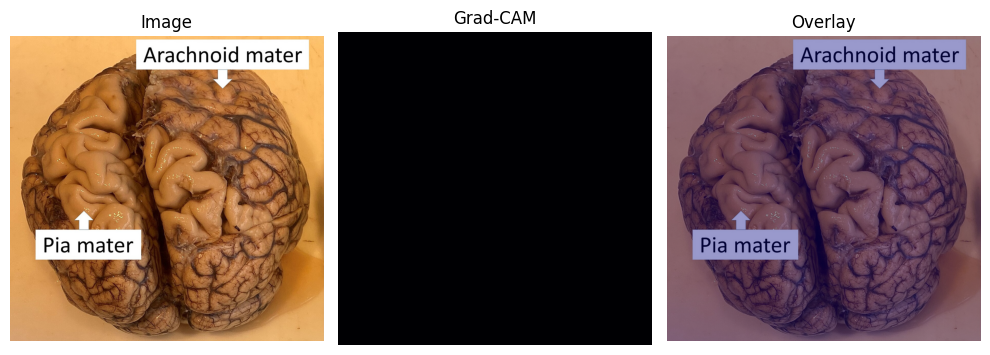


Grad-CAM: Craniotomy_Arachnoid.jpg
Top label: dura mater via prompt: an intraoperative photograph of dural membrane


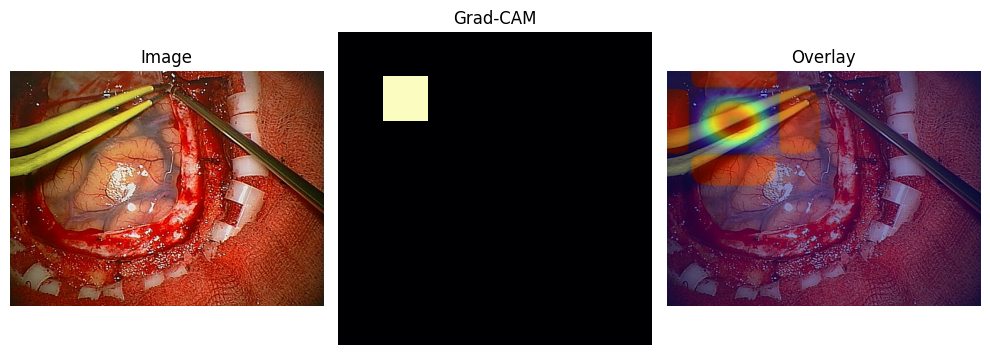


Grad-CAM: Dura_dissection.png
Top label: sulcus via prompt: an endoscopic surgical view of sulcus


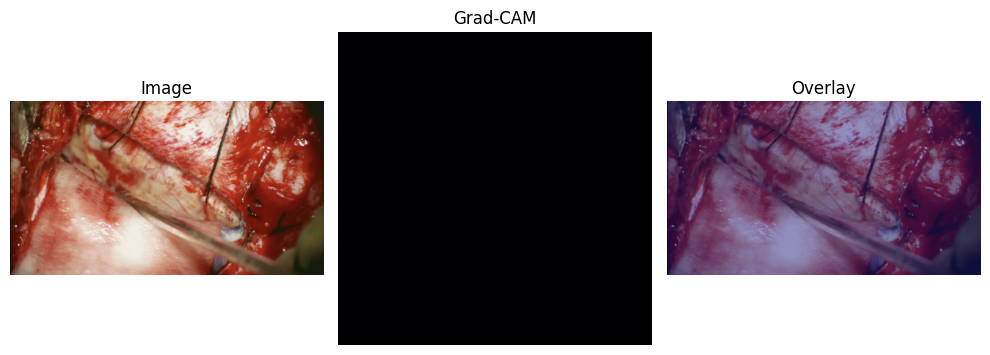


Grad-CAM: Gross_pathology_of_subarachnoid_hemorrhage.jpg
Top label: sulcus via prompt: an endoscopic surgical view of sulcus


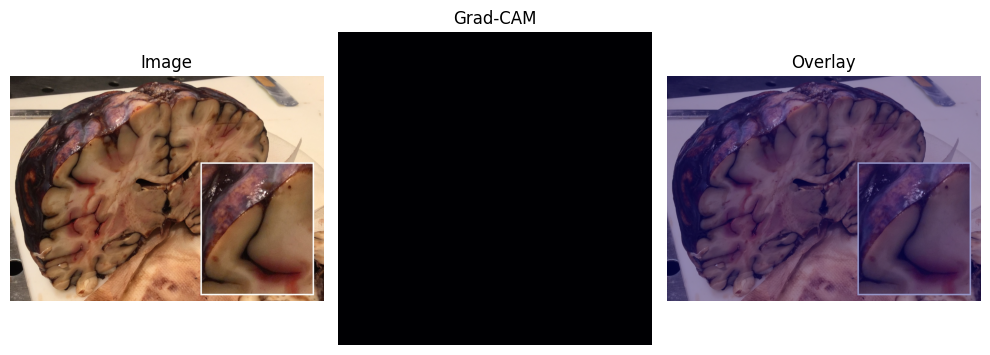


Grad-CAM: Human_brain_inferior_view_description.jpeg
Top label: brainstem via prompt: a medical photograph of brainstem


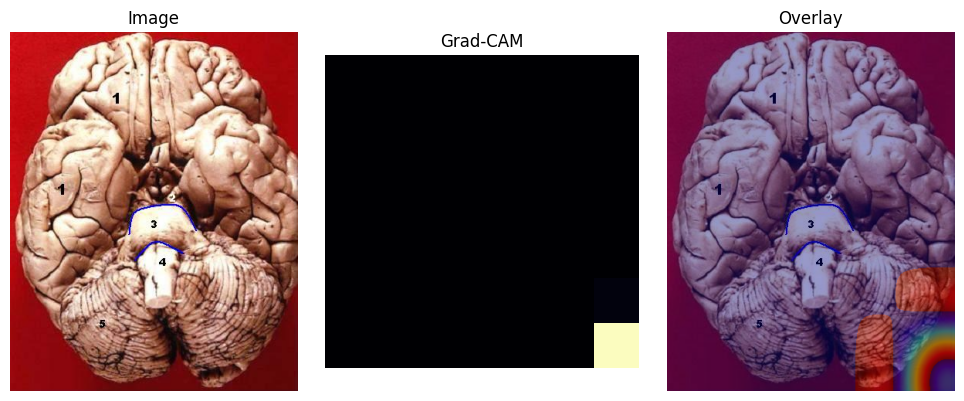


Grad-CAM: Human_brainstem-thalamus_posterior_view_description.jpeg
Top label: cranial nerve via prompt: a neurosurgical anatomy photo of cranial nerve root


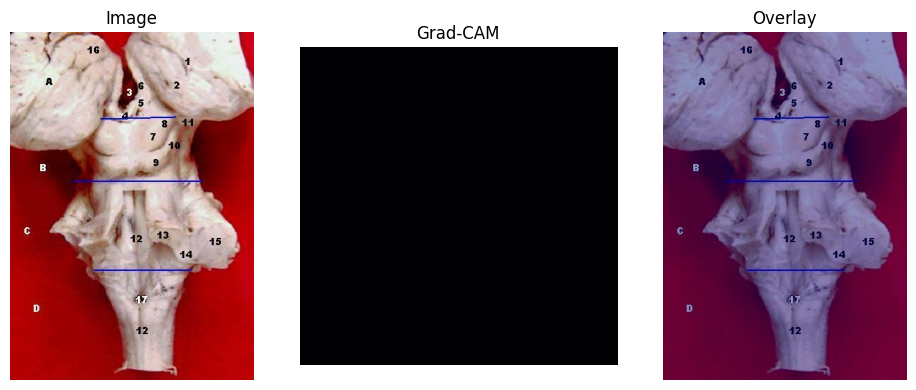


Grad-CAM: Human_brainstem_anterior_view_description_2.jpeg
Top label: cranial nerve via prompt: a neurosurgical anatomy photo of cranial nerve root


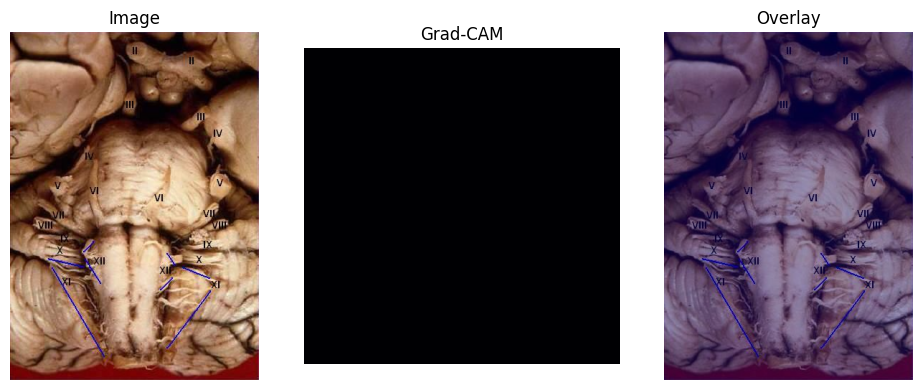


Grad-CAM: Human_cerebellum_posterior_view_description.jpeg
Top label: dura mater via prompt: a neurosurgical anatomy photo of dura mater


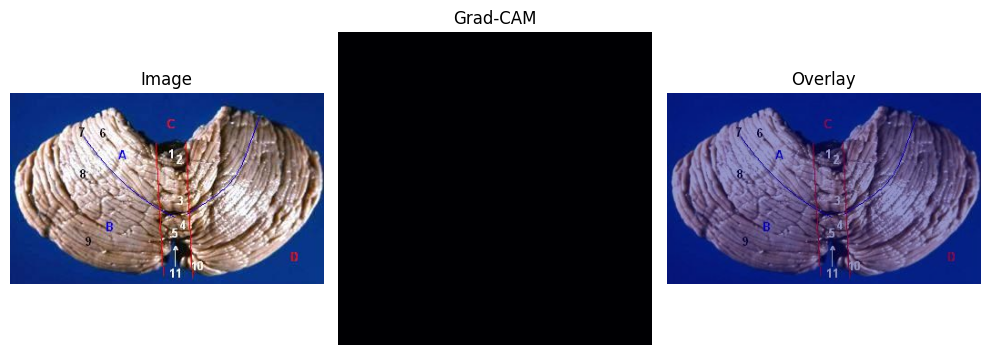


Grad-CAM: Slide6uu.jpeg
Top label: optic nerve via prompt: a neurosurgical anatomy photo of optic nerve


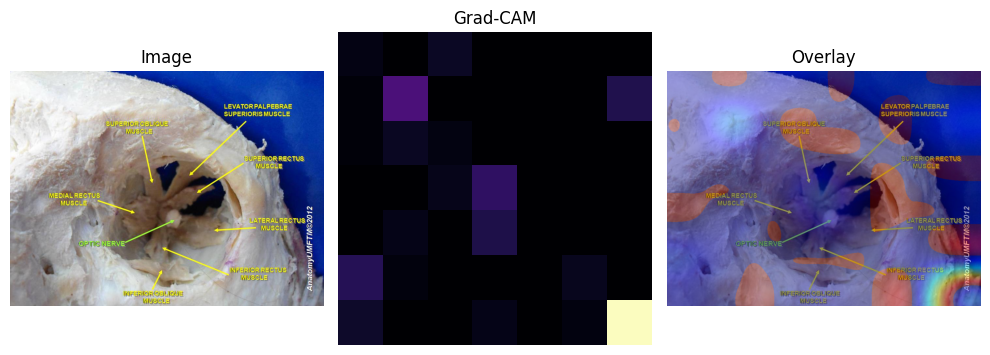


Grad-CAM: Trigeminal_nerve_neurovascular_conflict_microscope.jpeg
Top label: dura mater via prompt: an intraoperative photograph of dural membrane


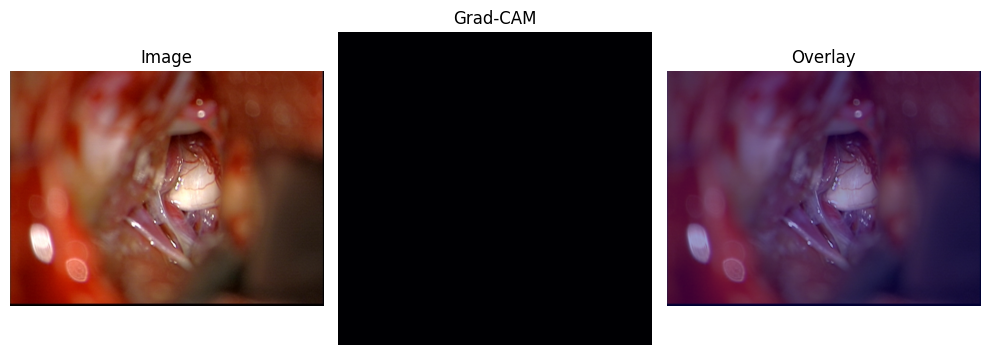


Grad-CAM: Use_of_a_surgical_sealant_film,_TissuePatchDural_(Tissuemed,_Leeds,_UK)_to_reinforce_and_seal_gaps_in_the_dura_mater..jpeg
Top label: sulcus via prompt: an endoscopic surgical view of sulcus


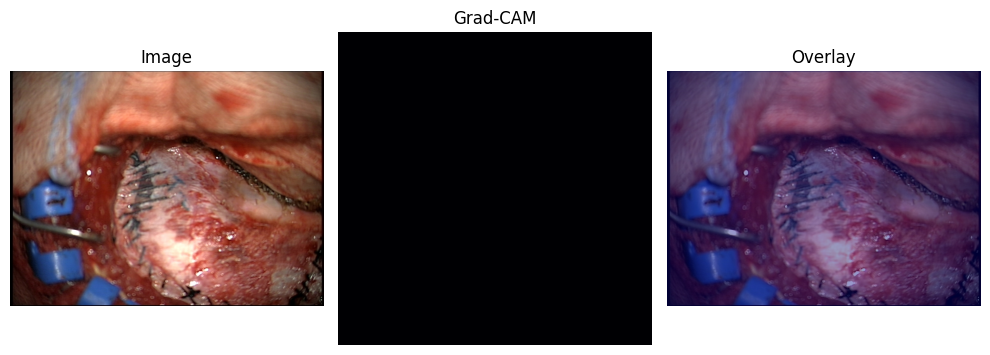


Grad-CAM: cranial_nerve_8.jpeg
Top label: cranial nerve via prompt: an endoscopic surgical view of cranial nerve root


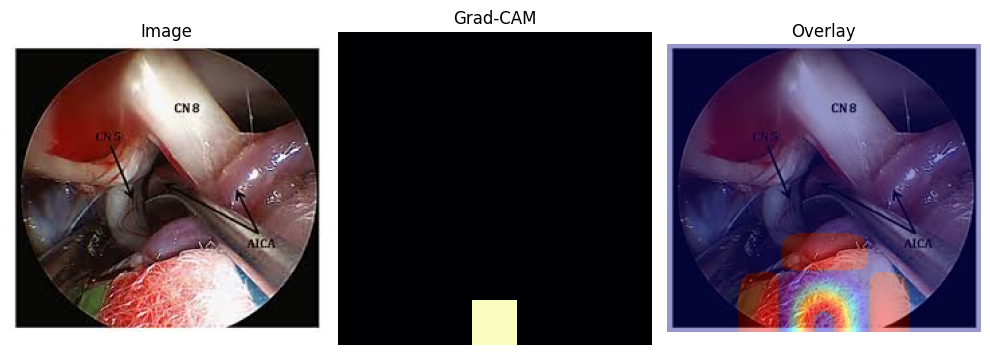


Grad-CAM: dura_matter_microscope_clean.jpeg
Top label: dura mater via prompt: a neurosurgical anatomy photo of dura


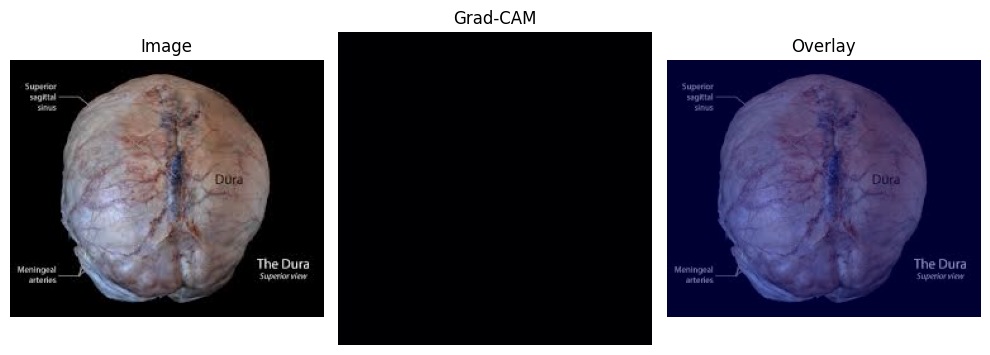


Grad-CAM: optic_nerve.jpeg
Top label: optic nerve via prompt: a medical photograph of optic disc


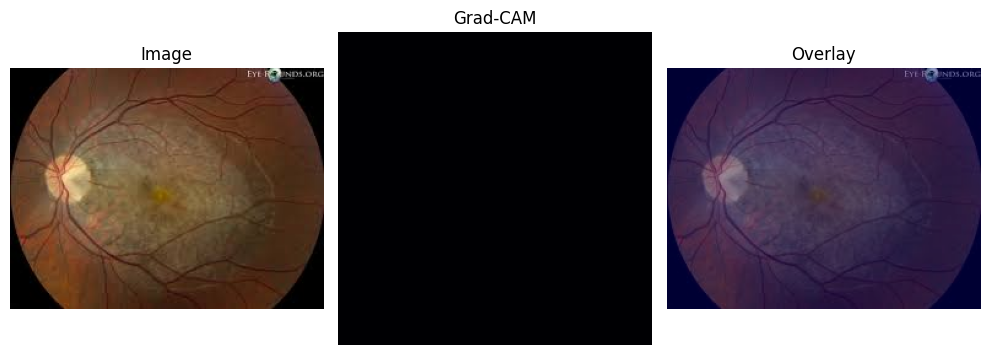

In [15]:
# Grad-CAM for CLIP RN50 image encoder
# We'll hook the last conv features and the linear projection to get class agnostic saliency wrt the max scoring prompt.
# Idea: find which spatial regions (conv feature maps) most influence the score for a chosen prompt.

import types

def get_rn50_visual(model):
    # open_clip RN50 visual backbone is in model.visual; final conv layer is layer4[-1].conv3 for ResNet-50
    return model.visual

class GradCAM:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.gradients = None
        self.activations = None

        visual = get_rn50_visual(model)
        target_layer = visual.layer4[-1].conv3  # last conv layer in ResNet-50

        # Save conv activations on forward and gradients on backward.
        def fwd_hook(module, inp, out):
            self.activations = out.detach()
        def bwd_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.fh = target_layer.register_forward_hook(fwd_hook)
        self.bh = target_layer.register_full_backward_hook(bwd_hook)

    def remove(self):
        self.fh.remove(); self.bh.remove()

    def __call__(self, img_tensor: torch.Tensor, text_feature: torch.Tensor):
        # Forward: get image embedding; normalize for cosine-like comparison.
        img_tensor = img_tensor.requires_grad_(True)
        image_features = self.model.encode_image(img_tensor)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        # Scalar score: similarity between image and the chosen text feature.
        score = (100.0 * (image_features * text_feature).sum(dim=-1)).sum()
        # Backward: gradients wrt the last conv features.
        self.model.zero_grad(set_to_none=True)
        score.backward(retain_graph=True)
        grads = self.gradients  # (N, C, H, W)
        acts = self.activations # (N, C, H, W)
        # Channel weights by global average pooling over H,W.
        weights = grads.mean(dim=(2,3), keepdim=True)
        # Weighted sum of activations across channels → class activation map (CAM).
        cam = (weights * acts).sum(dim=1, keepdim=False)
        cam = torch.relu(cam)
        # Normalize CAM to [0, 1] per image.
        cams = []
        for i in range(cam.shape[0]):
            c = cam[i]
            c = c - c.min()
            denom = c.max().clamp(min=1e-6)
            c = c / denom
            cams.append(c)
        cam = torch.stack(cams, dim=0)
        return cam.detach().cpu()


def overlay_heatmap(img: Image.Image, cam: np.ndarray, alpha: float = 0.35) -> Image.Image:
    # Resize CAM to image size, colorize, and blend with the image for visualization.
    img_np = np.array(img.convert("RGB"))
    h, w, _ = img_np.shape
    cam_resized = cv2.resize(cam, (w, h), interpolation=cv2.INTER_CUBIC)
    heat = (cam_resized * 255.0).astype(np.uint8)
    heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)[:, :, ::-1]  # BGR->RGB
    overlay = (alpha * heat + (1 - alpha) * img_np).astype(np.uint8)
    return Image.fromarray(overlay)

# Choose the best prompt for the top label to condition Grad-CAM.

def best_prompt_for_label(scores: dict, label: str, label_to_prompts: dict) -> str:
    prompts = label_to_prompts[label]
    best_p, best_s = None, -1
    for p in prompts:
        s = scores.get(p, 0.0)
        if s > best_s:
            best_p, best_s = p, s
    return best_p

@torch.no_grad()
def encode_single_text(prompt: str) -> torch.Tensor:
    tok = tokenizer([prompt]).to(device)
    feat = model.encode_text(tok)
    feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat

# Run Grad-CAM per image using the top predicted label and its best prompt.
assert model_name.startswith("RN"), "Grad-CAM cell only supports RN models; switch to attention rollout for ViT."
cam_engine = GradCAM(model)

for img_path in image_paths:
    img = Image.open(img_path).convert("RGB")
    print("\nGrad-CAM:", os.path.basename(img_path))
    scores = score_image_against_prompts(img, text_features, all_texts, T=T_star)
    label_scores = aggregate_by_label(scores, label_to_prompts, reduce="mean", multi_label=False) # Use multi_label=True for multi-label
    top_label = max(label_scores.items(), key=lambda x: x[1])[0]
    bp = best_prompt_for_label(scores, top_label, label_to_prompts)
    print("Top label:", top_label, "via prompt:", bp)

    img_tensor = preprocess_pil(img).to(device)
    tf = encode_single_text(bp)

    cam = cam_engine(img_tensor, tf)[0].numpy()
    over = overlay_heatmap(img, cam, alpha=0.4)

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.axis('off'); plt.title('Image')
    plt.subplot(1,3,2); plt.imshow(cam, cmap='magma'); plt.axis('off'); plt.title('Grad-CAM')
    plt.subplot(1,3,3); plt.imshow(over); plt.axis('off'); plt.title('Overlay')
    plt.tight_layout(); plt.show()

cam_engine.remove()

### Optional: Prompt calibration with a few labeled images
If you have 3–5 labeled images, you can estimate a temperature or per-label bias to calibrate scores.
Below is a simple temperature scaling example stub (disabled by default).


In [8]:
# Temperature scaling (optional small calibration)
# Purpose: learn a single scalar T to rescale logits, improving probability calibration on a tiny labeled set.
ENABLE_TEMP = False

# Provide a few labeled examples if available: [(image_path, "true_label"), ...]
labeled_examples = []  # Fill if available

def fit_temperature(text_features: torch.Tensor, all_texts: list[str], labeled_examples: list) -> float:
    # Optimize a scalar temperature T to minimize negative log-likelihood of the true labels.
    T = torch.tensor(1.0, device=device, requires_grad=True)
    optimizer = torch.optim.LBFGS([T], lr=0.1, max_iter=50)

    def closure():
        optimizer.zero_grad(set_to_none=True)
        loss_total = 0.0
        for img_path, true_label in labeled_examples:
            # Recompute probabilities for this image and divide logits by T.
            img = Image.open(img_path).convert("RGB")
            image_input = preprocess_pil(img).to(device)
            image_features = model.encode_image(image_input)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            logits = (100.0 * image_features @ text_features.T)[0] / T
            probs = logits.softmax(dim=-1)
            # Aggregate prompt probabilities per label by summing the prompts.
            label_probs = {}
            offset = 0
            for label, prompts in label_to_prompts.items():
                idxs = list(range(offset, offset + len(prompts)))
                p = probs[idxs].sum()
                label_probs[label] = p
                offset += len(prompts)
            # Negative log likelihood for the true label.
            denom = torch.stack(list(label_probs.values())).sum()
            loss = -torch.log(label_probs[true_label] / denom)
            loss_total = loss_total + loss
        loss_total.backward()
        return loss_total

    if len(labeled_examples) > 0:
        optimizer.step(closure)
        return float(T.detach().cpu())
    return 1.0

if ENABLE_TEMP and labeled_examples:
    T_star = fit_temperature(text_features, all_texts, labeled_examples)
    print("Fitted temperature:", T_star)
else:
    T_star = 1.0



### Commentary and Attribution
- This example adapts the CLIP zero-shot classification approach from Radford et al., 2021.
- Saliency uses a Grad-CAM adaptation over the RN50 image encoder.
- OpenCLIP library used for model weights and preprocessing.
- Changes from reference demos: domain-specific prompt templates, per-label prompt aggregation, Grad-CAM overlay, optional temperature scaling.

Discuss observed behavior: where prompts succeed, where they fail (domain shift), and how prompt ensembling or calibration helps.


Why is this important?
- Zero-shot recognition: Shows how text prompts can act as labels, enabling classification without task-specific training.
- Label efficiency: Useful when you have few/no annotations; you can still get a usable classifier by crafting prompts.
- Interpretability: Grad‑CAM visualizes where the model focuses to support its prediction, aiding trust and error analysis.
Prompt engineering: Demonstrates how phrasing/ensembling affects performance and how light calibration can stabilize results.

### Educational: Multi‑label scenes and thresholding
- Some images contain multiple structures. We can treat zero‑shot as multi‑label by keeping all labels above a threshold.
- Below, we show per‑label Grad‑CAM overlays for all labels with probability > 0.15.
- Tip: adjust the threshold to trade off precision vs recall.


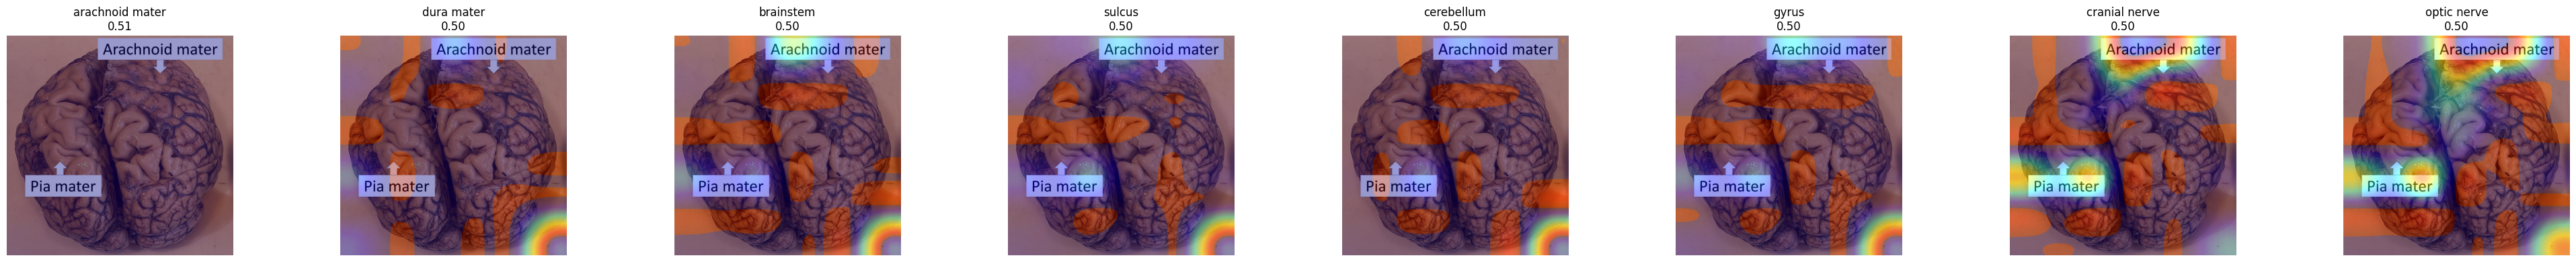

In [16]:
# Multi-label Grad-CAM overlays for labels above a probability threshold
threshold = 0.15

if len(image_paths) > 0:
    sel_idx = 0  # choose an image index
    img_path = image_paths[sel_idx]
    img = Image.open(img_path).convert("RGB")
    scores = score_image_against_prompts(img, text_features, all_texts, T=T_star)
    label_scores = aggregate_by_label(scores, label_to_prompts, reduce="mean", multi_label=True) # Use multi_label=True for multi-label

    # Keep labels with prob > threshold
    kept = [(lbl, p) for lbl, p in label_scores.items() if p > threshold]
    kept.sort(key=lambda x: -x[1])

    if len(kept) == 0:
        print("No labels above threshold. Lower it or choose another image.")
    else:
        img_tensor = preprocess_pil(img).to(device)
        plt.figure(figsize=(5*len(kept), 4))
        assert model_name.startswith("RN"), "Grad-CAM cell only supports RN models; switch to attention rollout for ViT."
        cam_engine = GradCAM(model)
        for j, (lbl, p) in enumerate(kept):
            # best prompt for this label
            bp = max(label_to_prompts[lbl], key=lambda prm: scores.get(prm, 0.0))
            tf = encode_single_text(bp)

            cam = cam_engine(img_tensor, tf)[0].numpy()
            over = overlay_heatmap(img, cam, alpha=0.4)

            ax = plt.subplot(1, len(kept), j+1)
            ax.imshow(over); ax.axis('off')
            ax.set_title(f"{lbl}\n{p:.2f}")
        plt.tight_layout(); plt.show()
        cam_engine.remove()
else:
    print("No images found. Add images and rerun.")

### Educational: Saliency maps (Grad-CAM) — why and how
- Why: to localize the evidence for a predicted label. The heatmap shows which image regions most influenced the image–text similarity for the chosen prompt.
- How: we backpropagate the image–text score through the RN50 image encoder, weight the last conv feature maps by the pooled gradients (Grad-CAM), and overlay the heatmap on the image.
- What to look for: concentrated heat around the anatomical structure (e.g., dura, optic disc). Diffuse or off-target heat can indicate prompt mismatch or domain shift.
- Gallery: below we show a 3×N grid per image (row 1: image, row 2: heatmap, row 3: overlay) across N different prompts for the same label to illustrate prompt sensitivity.


Image: Brain_with_arachnoid_and_pia_mater.jpg
Top label: arachnoid mater (0.047)


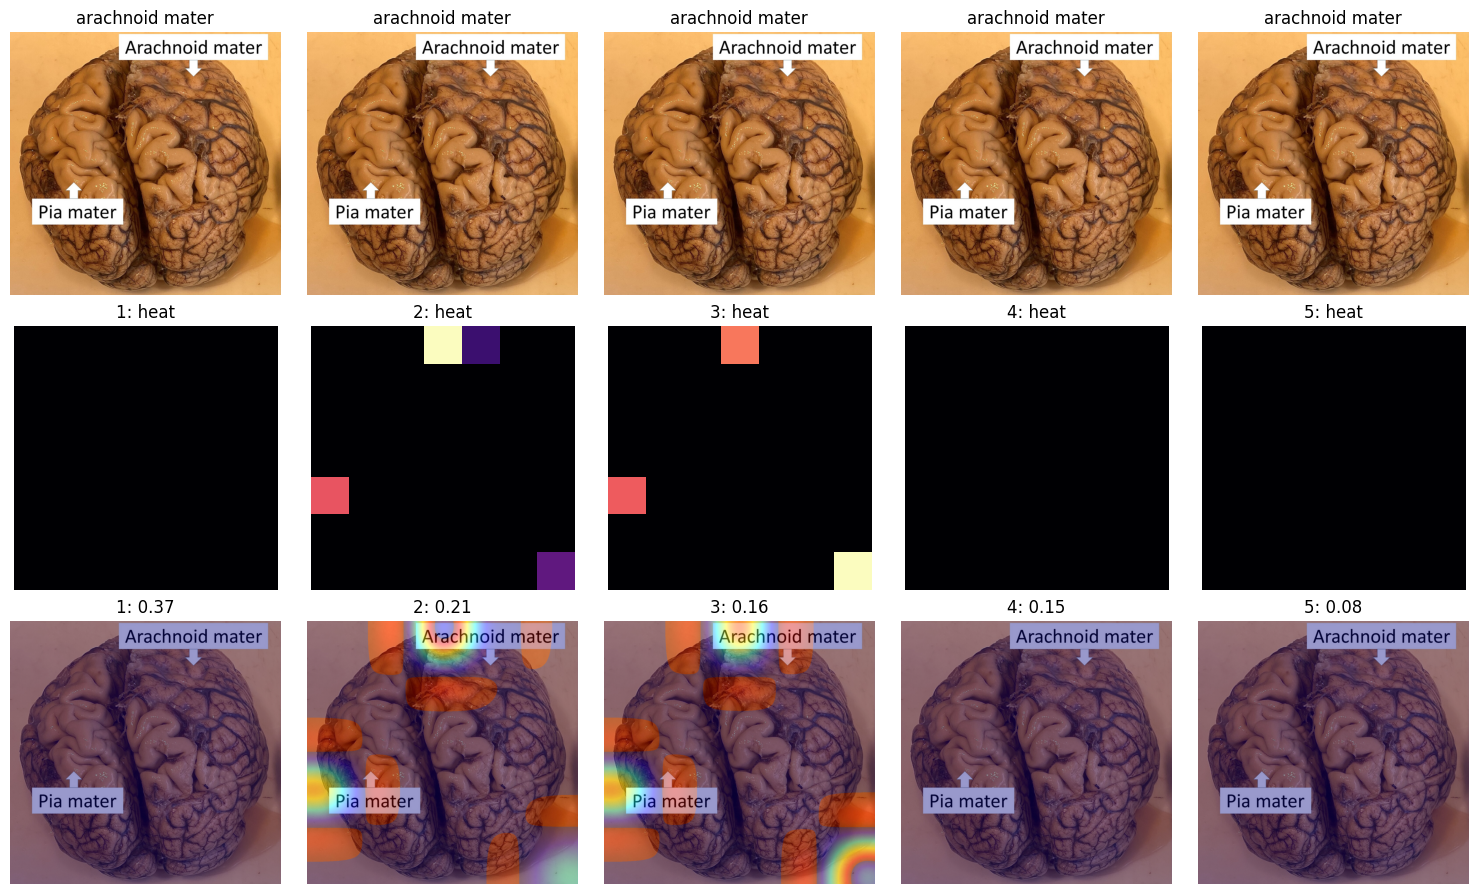

In [17]:
# Per-prompt saliency gallery (3×N) for the top label of a selected image
# Choose one image to inspect
if len(image_paths) > 0:
    sel_idx = 0  # change to view another image
    img_path = image_paths[sel_idx]
    img = Image.open(img_path).convert("RGB")
    print("Image:", os.path.basename(img_path))

    # Score prompts and choose the top label
    scores = score_image_against_prompts(img, text_features, all_texts, T=T_star)
    label_scores = aggregate_by_label(scores, label_to_prompts, reduce="mean", multi_label=False) # Use multi_label=True for multi-label
    top_label, top_prob = max(label_scores.items(), key=lambda x: x[1])
    print("Top label:", top_label, f"({top_prob:.3f})")

    # Pick N prompts for that label (best-first)
    prompts_for_label = label_to_prompts[top_label]
    prompts_sorted = sorted(prompts_for_label, key=lambda p: scores.get(p, 0.0), reverse=True)
    N = min(5, len(prompts_sorted))  # show up to 5 prompts
    chosen_prompts = prompts_sorted[:N]

    # Build saliency for each chosen prompt
    img_tensor = preprocess_pil(img).to(device)
    cams = []
    overlays = []
    assert model_name.startswith("RN"), "Grad-CAM cell only supports RN models; switch to attention rollout for ViT."
    cam_engine = GradCAM(model)
    for p in chosen_prompts:
        tf = encode_single_text(p)
        cam = cam_engine(img_tensor, tf)[0].numpy()
        over = overlay_heatmap(img, cam, alpha=0.4)
        cams.append(cam)
        overlays.append(over)
    cam_engine.remove()

    # Plot 3×N: original image row, heatmaps row, overlays row
    plt.figure(figsize=(3*N, 9))
    for j, p in enumerate(chosen_prompts):
        # row 1: image
        ax = plt.subplot(3, N, 1 + j)
        ax.imshow(img); ax.axis('off')
        ax.set_title(f"{top_label}")
        # row 2: heatmap
        ax = plt.subplot(3, N, 1*N + 1 + j)
        ax.imshow(cams[j], cmap='magma'); ax.axis('off')
        ax.set_title(f"{j+1}: heat")
        # row 3: overlay
        ax = plt.subplot(3, N, 2*N + 1 + j)
        ax.imshow(overlays[j]); ax.axis('off')
        ax.set_title(f"{j+1}: {scores.get(chosen_prompts[j], 0.0):.2f}")
    plt.tight_layout(); plt.show()
else:
    print("No images found. Add images to the folder and rerun.")